# VRNN-Copy1.ipynb

A PyTorch implementation of the [Variational Recurrent Neural Network](https://papers.nips.cc/paper_files/paper/2015/file/b618c3210e934362ac261db280128c22-Paper.pdf)



In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import lovely_tensors as lt
lt.monkey_patch()
%cd ./data/

/home/z/Dropbox (OIST)/code/python/pytorch/deep_explorations/rnn/data


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cuda:0


In [3]:
# Load training trajectories
coordinates = []
fnames = ['cte' + str(i) + '.pkl' for i in range(1,9)]
# fnames = ['circle2_triangle2_eight2_random.pkl']
# fnames = ['switch_circle2_circle2.pkl']
for fname in fnames:
    with open(fname, 'rb') as f:
        coordinates.append(pickle.load(f))

Coordinates[0] shape: torch.Size([969, 2])
Coordinates[1] shape: torch.Size([977, 2])
Coordinates[2] shape: torch.Size([975, 2])
Coordinates[3] shape: torch.Size([945, 2])
Coordinates[4] shape: torch.Size([962, 2])
Coordinates[5] shape: torch.Size([895, 2])
Coordinates[6] shape: torch.Size([953, 2])
Coordinates[7] shape: torch.Size([935, 2])


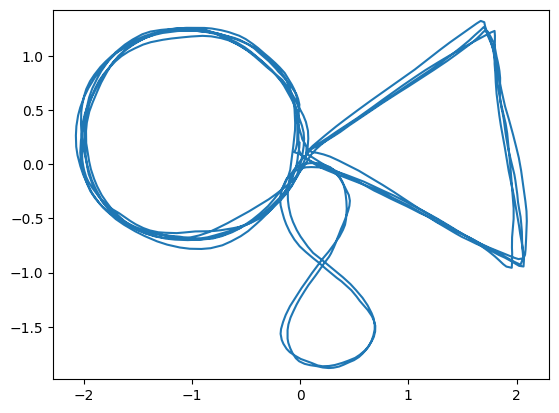

In [4]:
# plot the loaded array
fig = plt.figure()
plt.axis('equal')
if type(coordinates) == list:
    coords = coordinates[0]
    plt.plot(coords[:,0], coords[:,1])
    for i in range(len(coordinates)):
        coordinates[i] = torch.tensor(coordinates[i], dtype=torch.float32)
        print(f"Coordinates[{i}] shape: {coordinates[i].shape}")
else:
    plt.plot(coordinates[:,0], coordinates[:,1])
    coordinates = torch.tensor(coordinates, dtype=torch.float32)
    print(f"Coordinates shape: {coordinates.shape}")

In [5]:
# some utility functions

class FFP(nn.Module):
    """ A feedforward perceptron. """
    def __init__(self, sizes, nltypes, bias=True):
        """
            sizes: list with size of each layer.
            nltypes: list with nonlinearity type for each inner or
                output layer. Entries are 'relu', 'sig', 'tanh', 'soft',
                or 'linear'.
            bias: whether the layers have a bias unit
        """
        assert len(sizes)-1 == len(nltypes), "length mismatch in nltypes, sizes"
        super(FFP, self).__init__()
        # Add activation functions
        self.nlfs = []
        for nltype in nltypes:
            if nltype == "relu":
                self.nlfs.append(nn.ReLU())
            elif nltype == "sig":
                self.nlfs.append(nn.Sigmoid())
            elif nltype == "tanh":
                self.nlfs.append(nn.Tanh())
            elif nltype == "soft":
                self.nlfs.append(nn.Softplus())
            elif nltype == "linear":
                self.nlfs.append("linear")
            else:
                raise ValueError(f"unknown nonlinearity {nltype}")
        # create layers
        self.bias = bias
        self.sizes = sizes
        layers = []
        for lidx in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[lidx-1], sizes[lidx], bias=bias))
        self.layers = nn.ModuleList(layers)
                
    def forward(self, x):
        for lidx, layer in enumerate(self.layers):
            if self.nlfs[lidx] == "linear":
                x = layer(x)
            else:
                x = self.nlfs[lidx](layer(x))
        return x

class normal_FFP(nn.Module):
    """ A FFP that outputs parameters for a multivariate normal distribution.
    
        This is the same as the FFP class, except that the output layer is
        duplicated by concatenating an extra set of units with sigmoidal or
        softplus activation functions. This extra set of units corresponds to
        the entries of a diagonal covariance matrix, whereas the regular
        outputs corresponds to the means.
    """
    def __init__(self, sizes, nltypes, bias=True, use_soft=True):
        """
            sizes: list with size of each layer.
            nltypes: list with nonlinearity type for each inner or
                output layer. Entries are 'relu', 'sig', 'tanh', 'soft',
                or 'linear'.
            bias: whether the layers have a bias unit
            use_soft: if True, the units for the covariance matrix use a
                Softplus nonlinearity. If False, they use a Sigmoid.
        """
        assert len(sizes)-1 == len(nltypes), "length mismatch in nltypes, sizes"
        super(normal_FFP, self).__init__()
        self.n_layers = len(nltypes)
        # Add activation functions
        self.nlfs = []
        for nltype in nltypes:
            if nltype == "relu":
                self.nlfs.append(nn.ReLU())
            elif nltype == "sig":
                self.nlfs.append(nn.Sigmoid())
            elif nltype == "tanh":
                self.nlfs.append(nn.Tanh())
            elif nltype == "soft":
                self.nlfs.append(nn.Softplus())
            elif nltype == "linear":
                self.nlfs.append("linear")
            else:
                raise ValueError(f"unknown nonlinearity {nltype}")
        if use_soft:
            self.cov_nl = nn.Softplus()
        else:
            self.cov_nl = nn.Sigmoid()
        # create layers
        self.bias = bias
        self.sizes = sizes
        layers = []
        for lidx in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[lidx-1], sizes[lidx], bias=bias))
        # the last element in layers will be the sigmoidal variance layer
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=bias))
        self.layers = nn.ModuleList(layers)
                
    def forward(self, x):
        for lidx, layer in enumerate(self.layers[:-1]):
            if lidx == self.n_layers - 1:
                y = self.cov_nl(self.layers[-1](x))
            if self.nlfs[lidx] == "linear":
                x = layer(x)
            else:
                x = self.nlfs[lidx](layer(x))
        # return torch.concatenate((x, y), axis=-1)
        return x, y
        
class standard_SGD():
    """ An SGD optimizer for my FFP module. """
    def __init__(self, model, lr=0.1):
        """
            model: an instance of the FFP class
            lr: learning rate
        """
        self.model = model
        self.lr = lr
        
    def step(self):
        """ Updates the model's parameters. """
        for lidx, layer in enumerate(self.model.layers, 1):
            dw = self.lr * layer.weight.grad
            with torch.no_grad():
                layer.weight -= dw
                if self.model.bias:
                    layer.bias -= self.lr * layer.bias.grad
            
    def zero_grad(self):
        for layer in self.model.layers:
            layer.weight.grad.zero_()
            if self.model.bias:
                layer.bias.grad.zero_()

In [6]:
class VRNN(nn.Module):
    def __init__(self, x_conf, z_conf, prior_conf, enc_conf, dec_conf, f_conf):
        super(VRNN, self).__init__()
        self.phi_x = FFP(x_conf['sizes'],
                         x_conf['nltypes'],
                         x_conf['bias']).to(device)
        self.phi_z = FFP(z_conf['sizes'],
                         z_conf['nltypes'],
                         z_conf['bias']).to(device)
        self.phi_prior = normal_FFP(prior_conf['sizes'],
                                    prior_conf['nltypes'],
                                    prior_conf['bias'],
                                    prior_conf['use_soft']).to(device)
        self.phi_enc = normal_FFP(enc_conf['sizes'],
                                  enc_conf['nltypes'],
                                  enc_conf['bias'],
                                  enc_conf['use_soft']).to(device)
        self.phi_dec = normal_FFP(dec_conf['sizes'],
                                  dec_conf['nltypes'],
                                  dec_conf['bias'],
                                  dec_conf['use_soft']).to(device)
        self.f = FFP(f_conf['sizes'],
                     f_conf['nltypes'],
                     f_conf['bias']).to(device)
        
        self.h_n = f_conf['sizes'][-1]
        self.x_n = x_conf['sizes'][0]
        self.z_n = z_conf['sizes'][0]

    def forward(self, x):
        """ Perform inference for a sequence of inputs.

            Args:
                x: tensor with shape (T, x_n)
            Returns: 5-tuple with the following tensors
                inferred x values, shape (T, x_n)
                prior mu_z values, shape (T, n_z)
                prior sigma_z values, shape (T, n_z)
                mu_z vales from the encoder, shape (T, n_z)
                sigma_z values from the endoer, shape (T, n_z)
        """
        h = torch.zeros(self.h_n, device=device)
        T = x.shape[0]
        all_x_hat = torch.empty((T, self.x_n), device=device)
        all_prior_mu_z = torch.empty((T, self.z_n), device=device)
        all_prior_sigma_z = torch.empty((T, self.z_n), device=device)
        all_mu_z = torch.empty((T, self.z_n), device=device)
        all_sigma_z = torch.empty((T, self.z_n), device=device)
        for t in range(T):
            # extract features from x
            x_feat = self.phi_x(x[t])
            # pass x features through the encoder
            mu_z, sigma_z = self.phi_enc(torch.cat((x_feat, h)))
            # prior values of mu_z, sigma_z
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z with reparameterization
            eps = torch.randn_like(mu_z)
            z = eps.mul(sigma_z).add_(mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat, h)))
            # store results for time t
            all_x_hat[t, :] = x_hat
            all_prior_mu_z[t, :] = prior_mu_z
            all_prior_sigma_z[t, :] = prior_sigma_z
            all_mu_z[t, :] = mu_z
            all_sigma_z[t, :] = sigma_z

        return all_x_hat, all_prior_mu_z, all_prior_sigma_z, all_mu_z, all_sigma_z

    def generate(self, T):
        """ Generate a sequence of T synthetic values. """
        h = torch.zeros(self.h_n, device=device)
        all_x_hat = torch.empty((T, self.x_n), device=device)
        for t in range(T):
            # generate z's prior distribution
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z
            eps = torch.randn_like(prior_mu_z)
            z = eps.mul(prior_sigma_z).add_(prior_mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # extract features from x_hat
            x_feat = self.phi_x(x_hat)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat, h)))
            # store x value
            all_x_hat[t, :] = x_hat
        return all_x_hat


def KL_loss(mu1, sigma1, mu2, sigma2):
    """ KL divergence loss between two multivariate normal distributions.

        Both distributions are assumed to have diagonal covariance
        matrices. The constant factor is not included in the calculations,
        since it's not relevant for the gradient computation.

        Args:
            All inputs are tensors of shape (T, n_z)
            mu1: means for first distribution
            sigma1: diagonal elements of Cov. matrix for first distribtion
            mu2: means for second distribution
            sigma2: diagonal elements of Cov. matrix for second distribtion
        Returns:
            Scalar value from the sum of the T KL divergences.
    """
    tiny = 1e-16
    lds1 = (sigma1 + tiny).log().sum()
    lds2 = (sigma2 + tiny).log().sum()
    frac = (sigma1.pow(2) + (mu2 - mu1).pow(2)).div(sigma2.pow(2) + tiny)
    KLs = (lds2 - lds1) + 0.5 * frac.sum()
    return KLs

In [7]:
# Create the network, the optimizer, and the loss function
# NOTICE there are no batches. Learning a single pattern.

lr = 3e-4  # learning rate
x_n = 2  # Input dimension. This shouldn't change
h_n = 60 # hidden state dimension
z_n = 10  # latent space dimension
n_x_features = 15  # number of features to extract from inputs
n_z_features = 15  # number of features to extract from latent variables

phi_x_config = {'sizes': [x_n, n_x_features],
                'nltypes': ['relu'],
                'bias': True }
phi_z_config = {'sizes': [z_n, n_z_features],
                'nltypes': ['relu'],
                'bias': True }
phi_prior_config = {'sizes': [h_n, 20, z_n],
                    'nltypes': ['relu', 'linear'],
                    'bias': True,
                    'use_soft': False }
phi_enc_config = {'sizes': [n_x_features + h_n, 20, z_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': False }
phi_dec_config = {'sizes': [n_z_features + h_n, 20, x_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': True }
f_config = {'sizes': [n_x_features + n_z_features + h_n, h_n],
            'nltypes': ['tanh'],
            'bias': True }

all_generated = []
torch.manual_seed(345)

vrnn = VRNN(phi_x_config,
            phi_z_config,
            phi_prior_config,
            phi_enc_config,
            phi_dec_config,
            f_config)

optim = torch.optim.Adam(vrnn.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction='mean')

In [23]:
# training loop
n_epochs = 20  # number of epochs
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)
    
if not 'w' in locals():
    w = 0.
alpha = 5e-7

for epoch in range(n_epochs):
    acc_RE = 0
    acc_DE = 0
    for coords in coordinates:
        optim.zero_grad()
        x, pmu, psig, mu, sig = vrnn(coords[:-1])
        RE = mse_loss(x, coords[1:])
        DE = KL_loss(mu, sig, pmu, psig)
        loss = RE + w * DE
        loss.backward()
        optim.step()
        with torch.no_grad():
            w += alpha * (RE - w * DE)
        acc_RE += RE
        acc_DE += DE
    acc_RE /= n_pats
    acc_DE /= n_pats
    if epoch % 1 == 0:
        print(f"RE = {acc_RE:.4f}, w*DE = {w * acc_DE:.4f}, w = {w:.6f} at epoch {epoch}")

RE = 0.0214, w*DE = 0.1147, w = 0.000024 at epoch 0
RE = 0.0206, w*DE = 0.1129, w = 0.000024 at epoch 1
RE = 0.0203, w*DE = 0.1111, w = 0.000023 at epoch 2
RE = 0.0200, w*DE = 0.1094, w = 0.000023 at epoch 3
RE = 0.0197, w*DE = 0.1077, w = 0.000023 at epoch 4
RE = 0.0195, w*DE = 0.1061, w = 0.000022 at epoch 5
RE = 0.0190, w*DE = 0.1044, w = 0.000022 at epoch 6
RE = 0.0189, w*DE = 0.1028, w = 0.000022 at epoch 7
RE = 0.0184, w*DE = 0.1012, w = 0.000021 at epoch 8
RE = 0.0181, w*DE = 0.0996, w = 0.000021 at epoch 9
RE = 0.0182, w*DE = 0.0981, w = 0.000021 at epoch 10
RE = 0.0175, w*DE = 0.0966, w = 0.000020 at epoch 11
RE = 0.0174, w*DE = 0.0951, w = 0.000020 at epoch 12
RE = 0.0170, w*DE = 0.0936, w = 0.000020 at epoch 13
RE = 0.0168, w*DE = 0.0922, w = 0.000019 at epoch 14
RE = 0.0164, w*DE = 0.0907, w = 0.000019 at epoch 15
RE = 0.0164, w*DE = 0.0893, w = 0.000019 at epoch 16
RE = 0.0161, w*DE = 0.0879, w = 0.000018 at epoch 17
RE = 0.0158, w*DE = 0.0866, w = 0.000018 at epoch 18
RE 

In [18]:
# Generate a single trajectory
n_points = 1000

gen_coordinates = vrnn.generate(n_points).cpu().detach().numpy()

all_generated.append(gen_coordinates)

In [ ]:
# Train and generate trajectories, multiple training patterns
n_epicycles = 8
n_points = 1000
n_epochs = 50  # number of epochs per epicycle
alpha = 1e-7
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)

if not 'w' in locals():
    w = 0.

for epi in range(n_epicycles):
    for epoch in range(n_epochs):
        acc_RE = 0
        acc_DE = 0
        for coords in coordinates:
            optim.zero_grad()
            x, pmu, psig, mu, sig = vrnn(coords[:-1])
            RE = mse_loss(x, coords[1:])
            DE = KL_loss(mu, sig, pmu, psig)
            loss = RE + w * DE
            loss.backward()
            optim.step()
            with torch.no_grad():
                w += alpha * (RE - w * DE)
            acc_RE += RE
            acc_DE += DE
        acc_RE /= n_pats
        acc_DE /= n_pats
        if epoch % 2 == 0:
            print(f"RE = {acc_RE:.4f}, w*DE = {w * acc_DE:.4f}, w = {w:.6f} at epoch {epoch}")
        
    # Generate a trajectory
    gen_coordinates = vrnn.generate(n_points).cpu().detach().numpy()
    
    all_generated.append(gen_coordinates)

RE = 1.4575, w*DE = 0.0059, w = 0.000001 at epoch 0
RE = 1.3228, w*DE = 0.0167, w = 0.000003 at epoch 2
RE = 1.1608, w*DE = 0.0260, w = 0.000005 at epoch 4
RE = 0.8934, w*DE = 0.0337, w = 0.000007 at epoch 6
RE = 0.7215, w*DE = 0.0396, w = 0.000008 at epoch 8
RE = 0.5680, w*DE = 0.0446, w = 0.000009 at epoch 10
RE = 0.4547, w*DE = 0.0483, w = 0.000009 at epoch 12
RE = 0.3379, w*DE = 0.0495, w = 0.000010 at epoch 14
RE = 0.2340, w*DE = 0.0505, w = 0.000010 at epoch 16
RE = 0.1503, w*DE = 0.0515, w = 0.000011 at epoch 18
RE = 0.1015, w*DE = 0.0517, w = 0.000011 at epoch 20
RE = 0.0772, w*DE = 0.0515, w = 0.000011 at epoch 22
RE = 0.0654, w*DE = 0.0515, w = 0.000011 at epoch 24
RE = 0.0564, w*DE = 0.0514, w = 0.000011 at epoch 26
RE = 0.0497, w*DE = 0.0513, w = 0.000011 at epoch 28
RE = 0.0458, w*DE = 0.0512, w = 0.000011 at epoch 30
RE = 0.0418, w*DE = 0.0511, w = 0.000011 at epoch 32
RE = 0.0385, w*DE = 0.0510, w = 0.000011 at epoch 34
RE = 0.0358, w*DE = 0.0509, w = 0.000011 at epoch 3

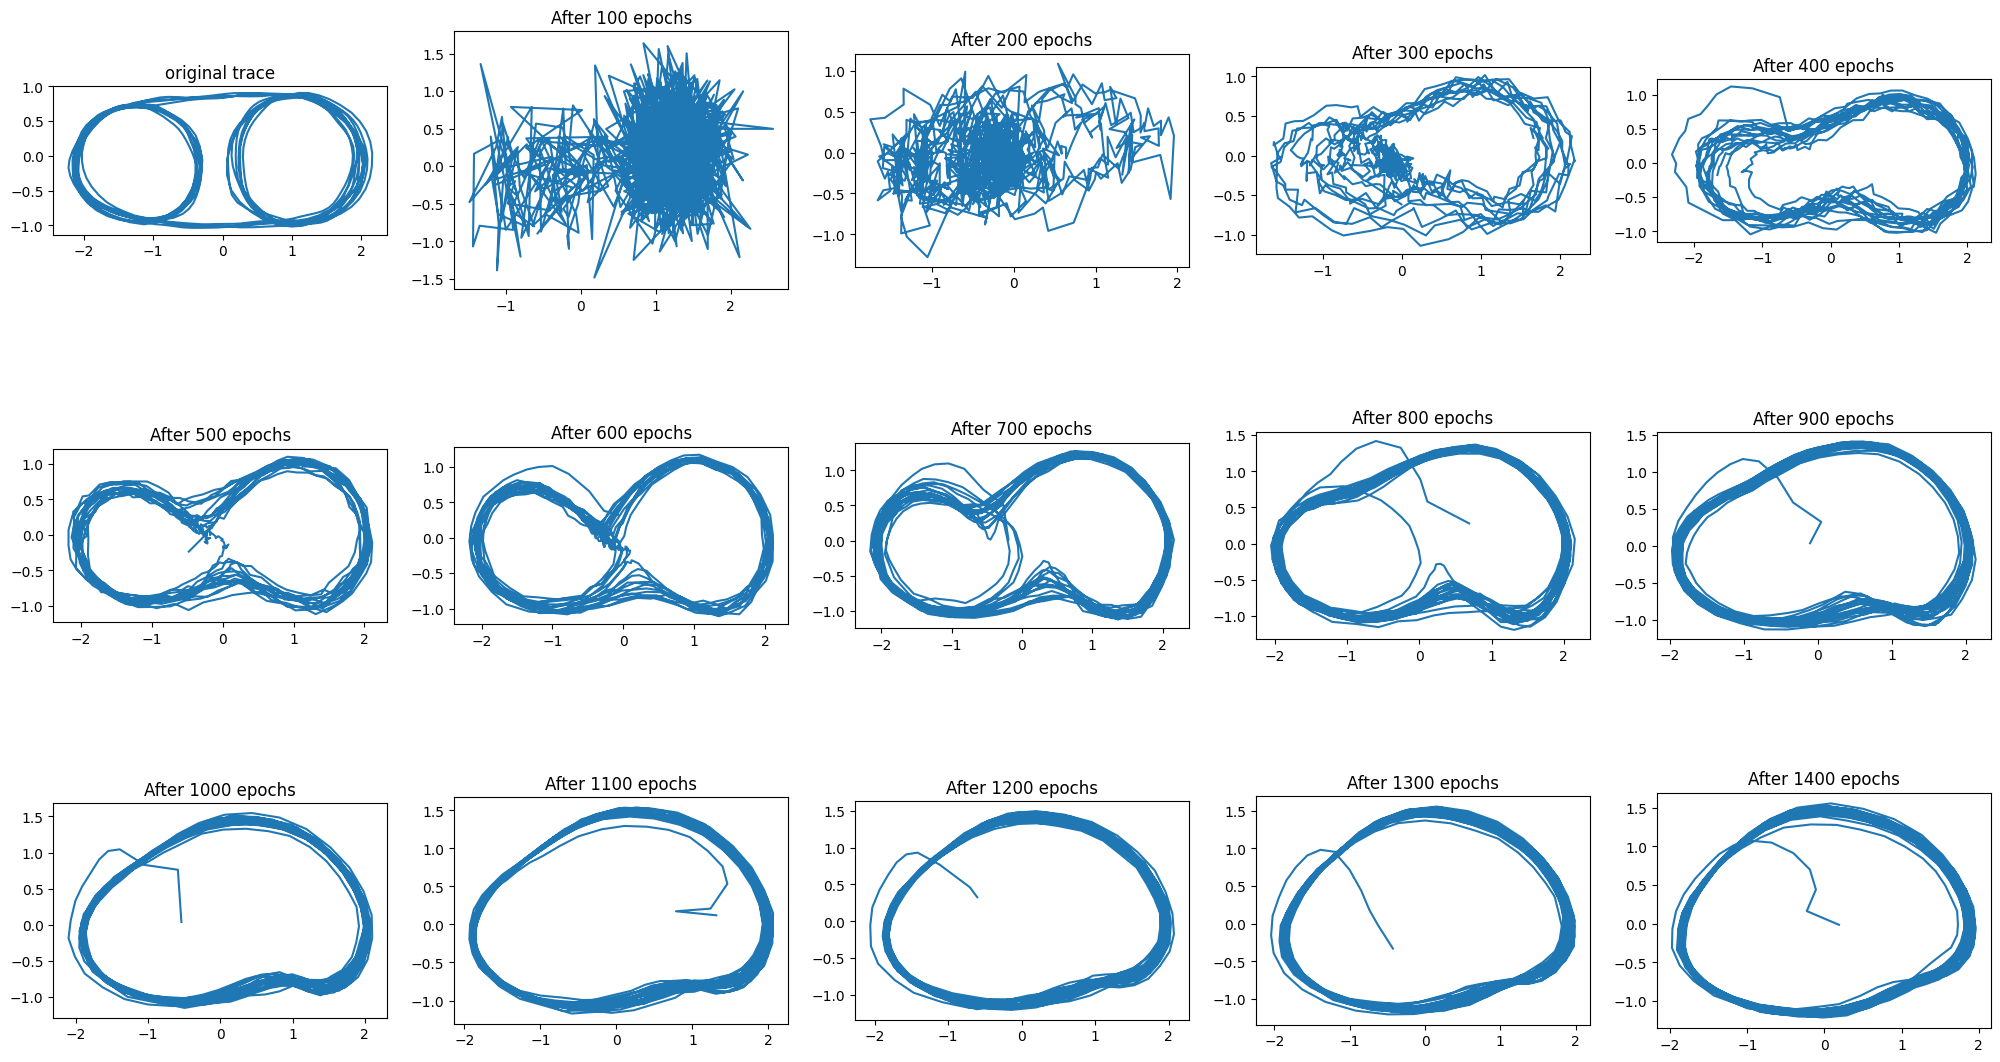

In [15]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5*n_cols, 4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates.cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

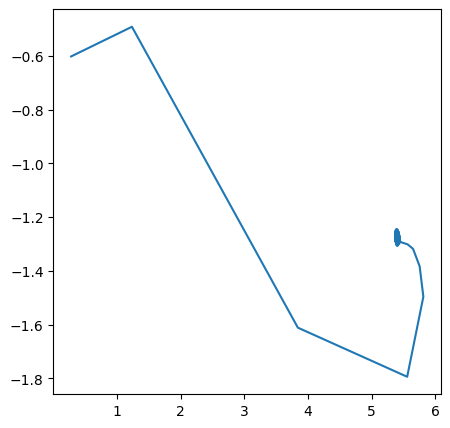

In [40]:
# generate a single trace 
gen_coords = vrnn.generate(10000).cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
plt.plot(gen_coords[:,0], gen_coords[:,1])

---
## Using GRU units

In [7]:
class VRNN_GRU(nn.Module):
    def __init__(self, x_conf, z_conf, prior_conf, enc_conf, dec_conf, f_conf):
        super(VRNN_GRU, self).__init__()
        self.phi_x = FFP(x_conf['sizes'],
                         x_conf['nltypes'],
                         x_conf['bias']).to(device)
        self.phi_z = FFP(z_conf['sizes'],
                         z_conf['nltypes'],
                         z_conf['bias']).to(device)
        self.phi_prior = normal_FFP(prior_conf['sizes'],
                                    prior_conf['nltypes'],
                                    prior_conf['bias'],
                                    prior_conf['use_soft']).to(device)
        self.phi_enc = normal_FFP(enc_conf['sizes'],
                                  enc_conf['nltypes'],
                                  enc_conf['bias'],
                                  enc_conf['use_soft']).to(device)
        self.phi_dec = normal_FFP(dec_conf['sizes'],
                                  dec_conf['nltypes'],
                                  dec_conf['bias'],
                                  dec_conf['use_soft']).to(device)
        self.f = nn.GRUCell(f_conf['sizes'][0],
                            f_conf['sizes'][1],
                            bias=f_conf['bias'],
                            device=device)
        
        self.h_n = f_conf['sizes'][-1]
        self.x_n = x_conf['sizes'][0]
        self.z_n = z_conf['sizes'][0]

    def forward(self, x):
        """ Perform inference for a sequence of inputs.

            Args:
                x: tensor with shape (T, x_n)
            Returns: 5-tuple with the following tensors
                inferred x values, shape (T, x_n)
                prior mu_z values, shape (T, n_z)
                prior sigma_z values, shape (T, n_z)
                mu_z vales from the encoder, shape (T, n_z)
                sigma_z values from the encoder, shape (T, n_z)
        """
        h = torch.zeros(self.h_n, device=device)
        T = x.shape[0]
        all_x_hat = torch.empty((T, self.x_n), device=device)
        all_prior_mu_z = torch.empty((T, self.z_n), device=device)
        all_prior_sigma_z = torch.empty((T, self.z_n), device=device)
        all_mu_z = torch.empty((T, self.z_n), device=device)
        all_sigma_z = torch.empty((T, self.z_n), device=device)
        for t in range(T):
            # extract features from x
            x_feat = self.phi_x(x[t])
            # pass x features through the encoder
            mu_z, sigma_z = self.phi_enc(torch.cat((x_feat, h)))
            # prior values of mu_z, sigma_z
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z with reparameterization
            eps = torch.randn_like(mu_z)
            z = eps.mul(sigma_z).add_(mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat)), h)
            # store results for time t
            all_x_hat[t, :] = x_hat
            all_prior_mu_z[t, :] = prior_mu_z
            all_prior_sigma_z[t, :] = prior_sigma_z
            all_mu_z[t, :] = mu_z
            all_sigma_z[t, :] = sigma_z

        return all_x_hat, all_prior_mu_z, all_prior_sigma_z, all_mu_z, all_sigma_z

    def generate(self, T):
        """ Generate a sequence of T synthetic values. """
        h = torch.zeros(self.h_n, device=device)
        all_x_hat = torch.empty((T, self.x_n), device=device)
        for t in range(T):
            # generate z's prior distribution
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z
            eps = torch.randn_like(prior_mu_z)
            z = eps.mul(prior_sigma_z).add_(prior_mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # extract features from x_hat
            x_feat = self.phi_x(x_hat)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat)), h)
            # store x value
            all_x_hat[t, :] = x_hat
        return all_x_hat

In [8]:
# Create the GRU network, the optimizer, and the loss function
# NOTICE there are no batches. Learning a single pattern.

lr = 3e-4  # learning rate
x_n = 2  # Input dimension. This shouldn't change
h_n = 60 # hidden state dimension
z_n = 10  # latent space dimension
n_x_features = 10  # number of features to extract from inputs
n_z_features = 16  # number of features to extract from latent variables

phi_x_config = {'sizes': [x_n, n_x_features],
                'nltypes': ['relu'],
                'bias': True }
phi_z_config = {'sizes': [z_n, n_z_features],
                'nltypes': ['relu'],
                'bias': True }
phi_prior_config = {'sizes': [h_n, 30, z_n],
                    'nltypes': ['relu', 'linear'],
                    'bias': True,
                    'use_soft': False }
phi_enc_config = {'sizes': [n_x_features + h_n, 30, z_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': False }
phi_dec_config = {'sizes': [n_z_features + h_n, 40, x_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': True }
f_config = {'sizes': [n_x_features + n_z_features, h_n],
            'bias': True }

all_generated = []
torch.manual_seed(345)

vrnn_gru = VRNN_GRU(phi_x_config,
            phi_z_config,
            phi_prior_config,
            phi_enc_config,
            phi_dec_config,
            f_config)

optim = torch.optim.Adam(vrnn_gru.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction='mean')

In [23]:
# training loop
n_epochs = 20  # number of epochs
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)
    
if not 'w' in locals():
    w = 0.
alpha = 5e-7

for epoch in range(n_epochs):
    acc_RE = 0
    acc_DE = 0
    for coords in coordinates:
        optim.zero_grad()
        x, pmu, psig, mu, sig = vrnn_gru(coords[:-1])
        RE = mse_loss(x, coords[1:])
        DE = KL_loss(mu, sig, pmu, psig)
        loss = RE + w * DE
        loss.backward()
        optim.step()
        with torch.no_grad():
            w += alpha * (RE - w * DE)
        acc_RE += RE
        acc_DE += DE
    acc_RE /= n_pats
    acc_DE /= n_pats
    if epoch % 2 == 0:
        print(f"RE = {acc_RE:.4f}, w*DE = {w * acc_DE:.4f}, w = {w:.6f} at epoch {epoch}")

RE = 0.0214, w*DE = 0.1147, w = 0.000024 at epoch 0
RE = 0.0206, w*DE = 0.1129, w = 0.000024 at epoch 1
RE = 0.0203, w*DE = 0.1111, w = 0.000023 at epoch 2
RE = 0.0200, w*DE = 0.1094, w = 0.000023 at epoch 3
RE = 0.0197, w*DE = 0.1077, w = 0.000023 at epoch 4
RE = 0.0195, w*DE = 0.1061, w = 0.000022 at epoch 5
RE = 0.0190, w*DE = 0.1044, w = 0.000022 at epoch 6
RE = 0.0189, w*DE = 0.1028, w = 0.000022 at epoch 7
RE = 0.0184, w*DE = 0.1012, w = 0.000021 at epoch 8
RE = 0.0181, w*DE = 0.0996, w = 0.000021 at epoch 9
RE = 0.0182, w*DE = 0.0981, w = 0.000021 at epoch 10
RE = 0.0175, w*DE = 0.0966, w = 0.000020 at epoch 11
RE = 0.0174, w*DE = 0.0951, w = 0.000020 at epoch 12
RE = 0.0170, w*DE = 0.0936, w = 0.000020 at epoch 13
RE = 0.0168, w*DE = 0.0922, w = 0.000019 at epoch 14
RE = 0.0164, w*DE = 0.0907, w = 0.000019 at epoch 15
RE = 0.0164, w*DE = 0.0893, w = 0.000019 at epoch 16
RE = 0.0161, w*DE = 0.0879, w = 0.000018 at epoch 17
RE = 0.0158, w*DE = 0.0866, w = 0.000018 at epoch 18
RE 

In [23]:
# Generate a trajectory
n_points = 1000

gen_coordinates = vrnn_gru.generate(n_points).cpu().detach().numpy()

all_generated.append(gen_coordinates)

In [ ]:
# Train and generate trajectories
n_epicycles = 10
n_points = 1000
n_epochs = 100  # number of epochs per epicycle
alpha = 1e-7
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)

if not 'w' in locals():
    w = 0.

for epi in range(n_epicycles):
    for epoch in range(n_epochs):
        acc_RE = 0
        acc_DE = 0
        for coords in coordinates:
            optim.zero_grad()
            x, pmu, psig, mu, sig = vrnn_gru(coords)
            RE = mse_loss(x, coords)
            DE = KL_loss(mu, sig, pmu, psig)
            loss = RE + w * DE
            loss.backward()
            optim.step()
            with torch.no_grad():
                w += alpha * (100. * RE - w * DE)
            acc_RE += RE
            acc_DE += DE
        acc_RE /= n_pats
        acc_DE /= n_pats
        if epoch % 40 == 0:
            print(f"RE = {acc_RE:.5f}, w*DE = {w * acc_DE:.5f}, w = {w:.8f} at epoch {epoch}")
    print(f"epicycle {epi} completed.")
    print("-------------------------------------------------------")
        
    # Generate a trajectory
    gen_coordinates = vrnn_gru.generate(n_points).cpu().detach().numpy()
    
    all_generated.append(gen_coordinates)

RE = 0.00041, w*DE = 0.35487, w = 0.00007460 at epoch 0
RE = 0.00039, w*DE = 0.31035, w = 0.00006524 at epoch 40
RE = 0.00037, w*DE = 0.27185, w = 0.00005715 at epoch 80
epicycle 0 completed.
-------------------------------------------------------
RE = 0.00036, w*DE = 0.25462, w = 0.00005353 at epoch 0
RE = 0.00035, w*DE = 0.22371, w = 0.00004703 at epoch 40
RE = 0.00035, w*DE = 0.19704, w = 0.00004142 at epoch 80
epicycle 1 completed.
-------------------------------------------------------
RE = 0.00033, w*DE = 0.18506, w = 0.00003890 at epoch 0


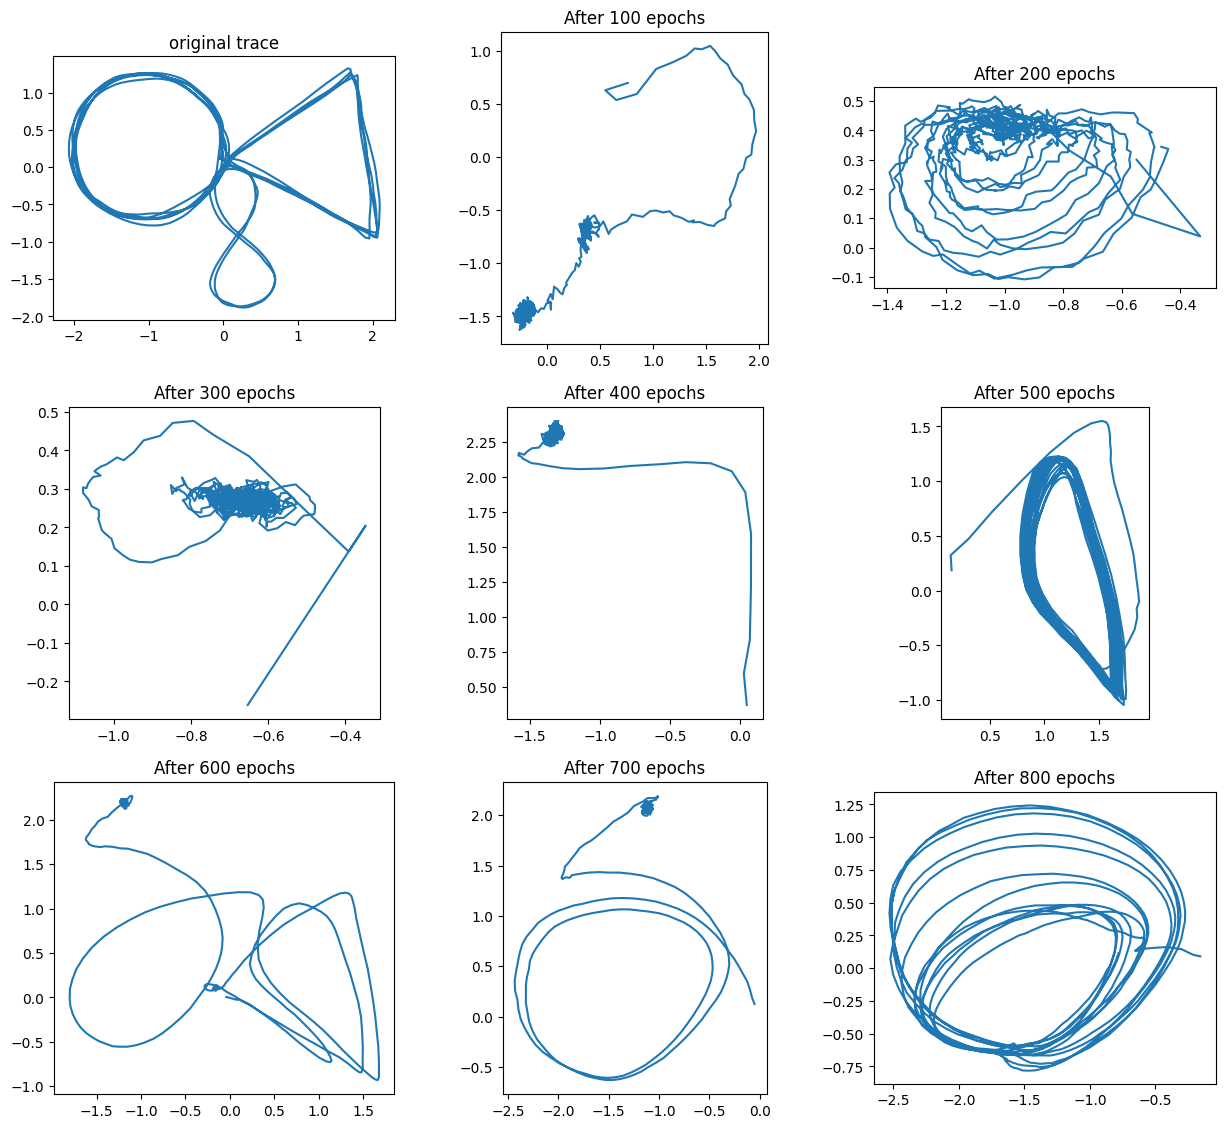

In [14]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5*n_cols, 4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates[0].cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

Text(0.5, 1.0, 'inferred trace')

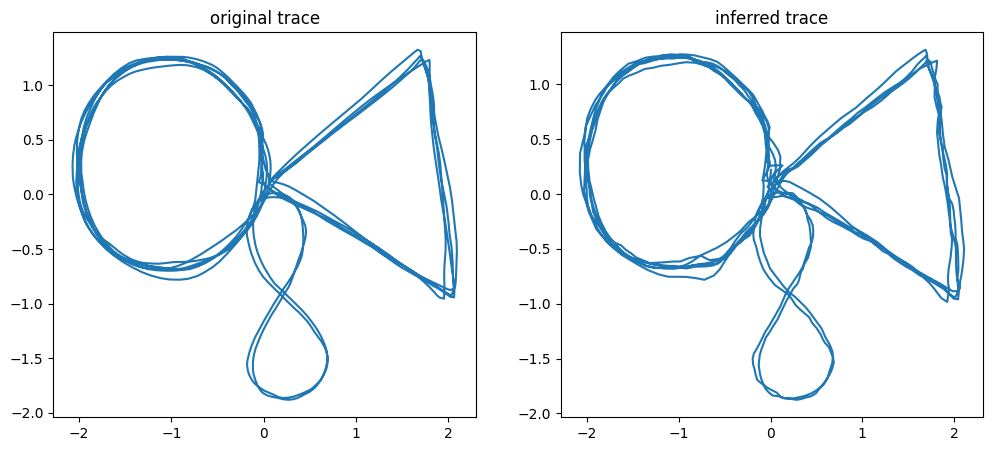

In [15]:
# Reconstruct with the inference mechanism
coords = coordinates[0]
with torch.no_grad():
    x, pmu, psig, mu, sig = vrnn_gru(coords)

gen_coords = x.cpu().detach().numpy()
orig_coords = coords.cpu().detach().numpy()

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
axs[0].plot(orig_coords[:,0], orig_coords[:,1])
axs[0].set_title("original trace")
axs[1].plot(gen_coords[:,0], gen_coords[:,1])
axs[1].set_title("inferred trace")

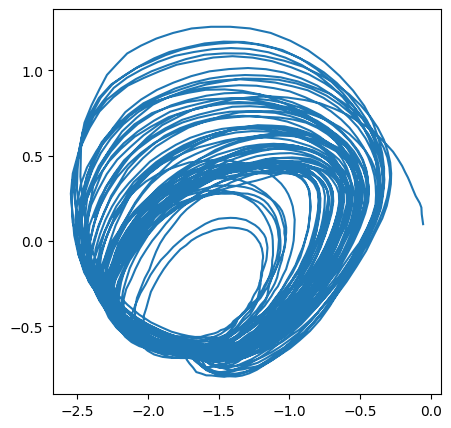

In [16]:
# generate a single trace 
gen_coords = vrnn_gru.generate(5000).cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
plt.plot(gen_coords[:,0], gen_coords[:,1])

---
## Save the state of a network

In [ ]:
# Save the state of a network
torch.save(vrnn_gru.state_dict(), 'cte_gru_1500e_corrected.pth')

In [ ]:
# load model
x_n = 2  # Input dimension. This shouldn't change
h_n = 60 # hidden state dimension
z_n = 10  # latent space dimension
n_x_features = 15  # number of features to extract from inputs
n_z_features = 15  # number of features to extract from latent variables

phi_x_config = {'sizes': [x_n, n_x_features],
                'nltypes': ['relu'],
                'bias': True }
phi_z_config = {'sizes': [z_n, n_z_features],
                'nltypes': ['relu'],
                'bias': True }
phi_prior_config = {'sizes': [h_n, 20, z_n],
                    'nltypes': ['relu', 'linear'],
                    'bias': True,
                    'use_soft': False }
phi_enc_config = {'sizes': [n_x_features + h_n, 20, z_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': False }
phi_dec_config = {'sizes': [n_z_features + h_n, 20, x_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': True }
f_config = {'sizes': [n_x_features + n_z_features + h_n, h_n],
            'nltypes': ['tanh'],
            'bias': True }

model = VRNN(phi_x_config,
            phi_z_config,
            phi_prior_config,
            phi_enc_config,
            phi_dec_config,
            f_config)
model.load_state_dict(torch.load('cte_nz10_3000e.pth'))
